In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path
from tqdm import tqdm
import fastai
from fastai.metrics import accuracy
from fastai.vision import (
    models, ImageList, imagenet_stats, partial, cnn_learner, ClassificationInterpretation, to_np,
)

import os
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb
from pathlib import Path
import albumentations as A
import random

print(f"Fast.ai version = {fastai.__version__}")

/home/narek/anaconda3/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


Fast.ai version = 1.0.60


In [3]:
doc_aug = A.Compose([
    A.HorizontalFlip(p=0.8),
    A.RandomBrightness(p=0.8, limit=0.4),
    A.RandomContrast(p=0.8, limit=0.4),
    A.Blur(blur_limit=2),
    A.ShiftScaleRotate(shift_limit=0.1625, scale_limit=0.6, rotate_limit=45, p=0.8)
], p=1)

for thing in ['shaver', 'smart-baby-bottle', 'toothbrush', 'wake-up-light']:
    print('Augmentating ' + thing)
    for i in range(1, 17):
        image = cv2.imread(f'./data/{thing}/image{i}.jpg')
        image = cv2.resize(image, (256, 256))
        for j in tqdm(range(128)):
            augmented = doc_aug(image=image, mask=None, bboxes=[], category_id=[])
            #image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)

            cv2.imwrite(f'data/{thing}/form_aug_{i}_{j}.jpg', augmented['image'])



  0%|          | 0/128 [00:00<?, ?it/s]

Augmentating shaver


  0%|          | 0/128 [00:00<?, ?it/s]

Augmentating smart-baby-bottle


  0%|          | 0/128 [00:00<?, ?it/s]

Augmentating toothbrush


  0%|          | 0/128 [00:00<?, ?it/s]

Augmentating wake-up-light


100%|██████████| 128/128 [00:00<00:00, 477.94it/s]


In [4]:
#DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS        = 10
LEARNING_RATE = 1e-4
IM_SIZE       = 300

BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50

path = Path('./data')

data = (
    ImageList.from_folder(path)
    .split_by_rand_pct(valid_pct=0.2, seed=10)
    .label_from_folder()
    .transform(size=IM_SIZE)
    .databunch(bs=BATCH_SIZE)
    .normalize(imagenet_stats)
)

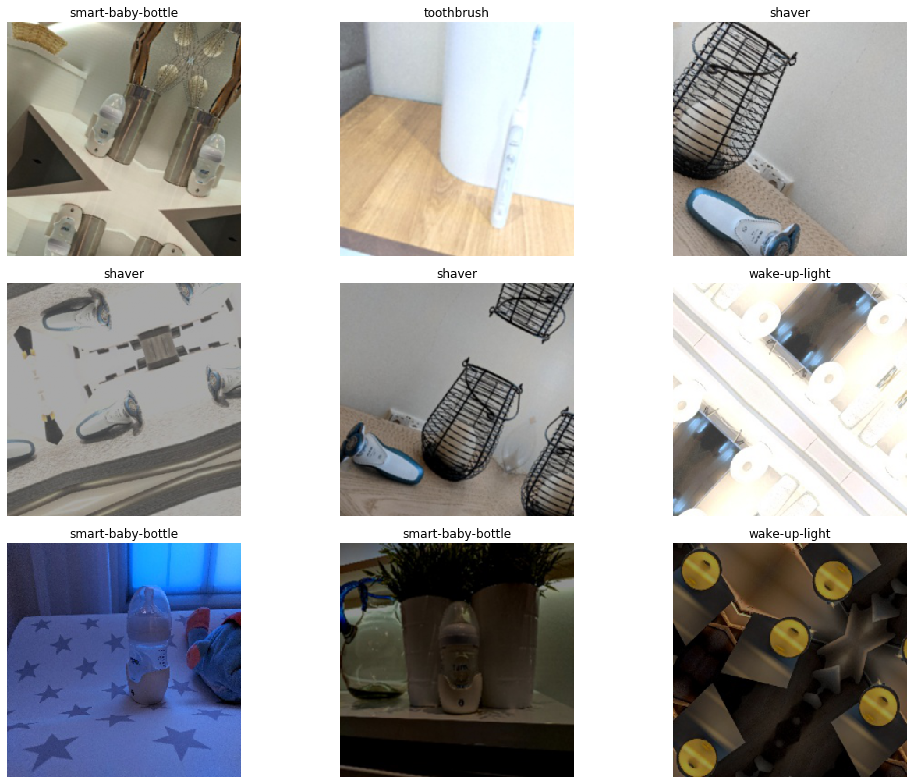

In [5]:
data.show_batch(rows=3, figsize=(15,11))

In [6]:
print(f'number of classes: {data.c}')
print(data.classes)

number of classes: 4
['shaver', 'smart-baby-bottle', 'toothbrush', 'wake-up-light']


In [7]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (6605 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
toothbrush,toothbrush,toothbrush,toothbrush,toothbrush
Path: data;

Valid: LabelList (1651 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
toothbrush,wake-up-light,toothbrush,smart-baby-bottle,shaver
Path: data;

Test: None>

In [8]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    #callback_fns=[partial(TrainMetricsRecorder, show_graph=True)]
)

In [9]:
learn.unfreeze()

In [10]:
learn.fit(EPOCHS, LEARNING_RATE)

epoch,train_loss,valid_loss,accuracy,time
0,0.114784,0.020626,0.995760,01:25
1,0.094253,0.022865,0.989703,01:25
2,0.077523,0.019163,0.994549,01:23
3,0.081460,0.017812,0.994549,01:21
4,0.040427,0.029462,0.992732,01:21
5,0.046448,0.007967,0.996366,01:21
6,0.032377,0.008289,0.996972,01:22
7,0.037188,0.020496,0.996366,01:21
8,0.015705,0.008573,0.998183,01:21
9,0.031738,0.018551,0.994549,01:21


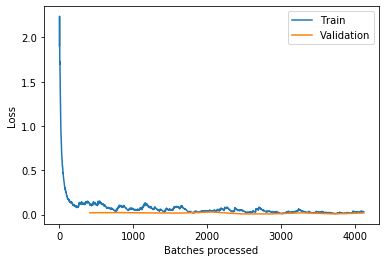

In [11]:
learn.recorder.plot_losses()

In [12]:
_, validation_accuracy = learn.validate(learn.data.valid_dl, metrics=[accuracy])
print(f'Accuracy on validation set: {100*float(validation_accuracy):3.2f}')

Accuracy on validation set: 99.45


In [13]:
interp = ClassificationInterpretation.from_learner(learn)

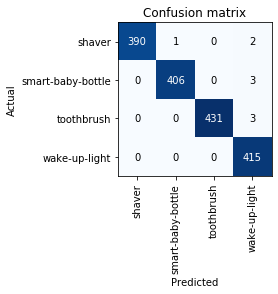

In [14]:
interp.plot_confusion_matrix()

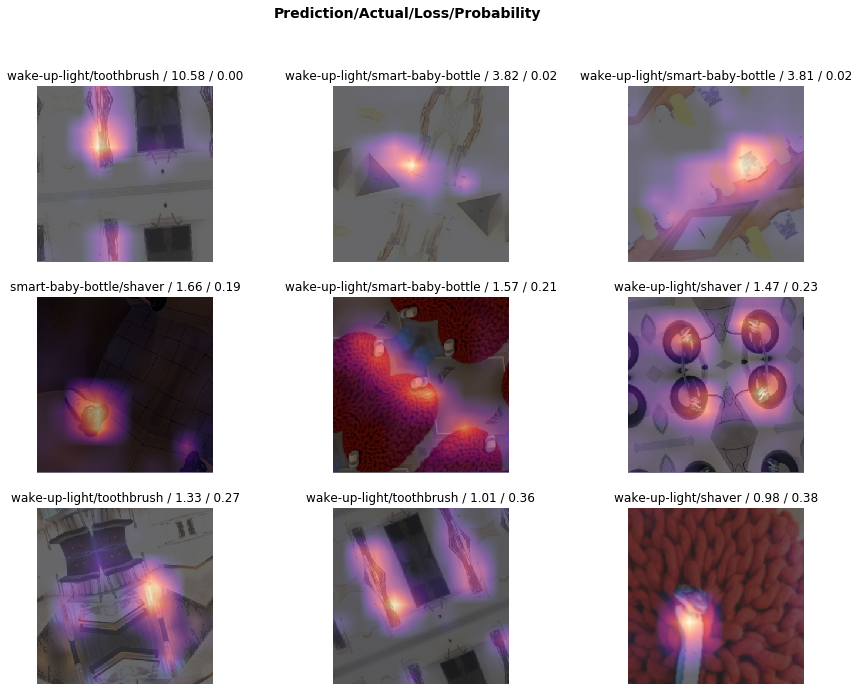

In [15]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

In [16]:
learn.path = Path('.')
learn.save('model', return_path=True)

PosixPath('models/model.pth')